## VGG Follow Things Around v2 beta

**[Follow Things Around](https://www.robots.ox.ac.uk/~vgg/software/follow-things-around/) is a program for easily detecting and tracking animals in videos, no programming skills required.**

You can open this notebook in Google Colab using the button below:

<a target="_blank" href="https://colab.research.google.com/github/ox-vgg/follow-things-around/blob/v2_beta1/follow-things-around-v2-beta.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Models supported**

In Follow Things Around v2, we support the following detection models and animal types:

| Detection model                                                      | What it can detect                                                             |
|----------------------------------------------------------------------|--------------------------------------------------------------------------------|
| [MegaDetectorV6](https://github.com/microsoft/CameraTraps/tree/main) | Various animals, people, and vehicles                                          |
| Our chimpanzee face detector (coming soon)                           | Chimpanzee faces                                                               |
| Our primate/chimp body detector (coming soon)                        | Primates/chimpanzees (more details coming soon)                                |
| COCO-pretrained model (coming soon)                                  | Birds, cats, dogs, horses, sheep, cows, elephants, bears, zebras, and giraffes |

**v2 updates**

This notebook is an early beta version of Follow Things Around v2. If you would like to receive updates when the v2 version is officially released, please [sign up here](https://docs.google.com/forms/d/e/1FAIpQLSdT0sa4AsRwo1m0qGDhr7GI9t2Z-A8Vko7bgDERdbh-MHVnUA/viewform).

**How it works**

Follow Things Around works by performing a two-step approach called
"tracking by detection".  First, it detects the "things" of interest
in each frame of a video, and then it tracks those objects by
associating detections across frames to form individual tracks, while
also filling in gaps from the detector.

**About**

If you have any questions, feedback, or issues, please contact [Horace
Lee](mailto:horacelee@robots.ox.ac.uk). For more details, please visit our [software webpage](https://www.robots.ox.ac.uk/~vgg/software/follow-things-around/).

## 1 - Read Me First

This project is a [Jupyter](https://jupyter.org/) notebook to
perform tracking by detection of multiple objects in videos and was
designed to run in [Google
Colab](https://colab.research.google.com/).  If you are not reading
this notebook in Google Colab, click
[here](https://colab.research.google.com/github/ox-vgg/follow-things-around/blob/v2_beta1/follow-things-around-v2-beta.ipynb).

### 1.1 - What is, and how to use, a Jupyter notebook

A Jupyter notebook is a series of "cells".  Each cell contains either text (like this one) or code (like others below).  A cell that contains code will have a "Run cell" button on the left side like this
"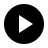".
When you click the "Run cell" button, the code in that cell will run and when it finishes, a green check mark appears next to the "Run cell" button".  You need to wait for the code in that cell to finish before "running" the next cell.


### 1.2 - Particulars of this notebook

This notebook was designed to run in Google Colab and to analyse
videos stored on Google Drive.  It will also save the analysis results
back to Google Drive.  As such, it requires a Google account.

You must run the cells in this notebook one after the other since each
cell is dependent on the results of the previous cell.

This notebook also has some interactive cells, namely in the options
sections.  After setting their values, these cells must be run, just
like other code cells.  Setting their values only has effect after you
"run" their cell.

### 1.3 - Testing this notebook

We recommend you first test this notebook with a short video, under a few minutes long.  Afterwards, you can run it on a longer video.

### 1.4 - Moving forward

You can run this notebook on Google Colab but if you have a large
collection of videos or if your videos are particularly long,
you may end up using up all of your free Colab resources.

Once you've tested Follow Things Around with a few of your videos,
it may be worth running this on your own computers.  Contact us if
you need help to do that.  Alternatively, you can purchase
additional "compute units" with a
[Colab paid plan](https://colab.research.google.com/signup).

## 2 - Setup

### 2.1 - Check for GPU access

A GPU is highly recommended for faster processing speeds, as your videos might take a long time to process without a GPU.

In [1]:
#@markdown By default, this notebook will run with a GPU.  However, it
#@markdown is possible that you were not allocated one, typically
#@markdown because you've used up all your GPU resources.  If you get
#@markdown a message saying that you do not have access to a GPU,
#@markdown navigate to "Edit" -> "Notebook Settings" and select "GPU"
#@markdown from the "Hardware Accelerator" menu.  Once you change it,
#@markdown you need to run this cell again.

import torch.cuda

if torch.cuda.is_available():
    USE_GPU = True
    print("You are using this GPU:")
    print(
        "GPU %d: %s (%d GB)"
        % (
            torch.cuda.current_device(),
            torch.cuda.get_device_name(),
            torch.cuda.get_device_properties(
                torch.cuda.current_device()
            ).total_memory
            * 1e-9,
        )
    )
else:
    USE_GPU = False
    print("You are NOT connected to a GPU.  This will run very slow.")
    print("Consider reconnecting to a runtime with GPU access.")

You are using this GPU:
GPU 0: Tesla T4 (15 GB)


### 2.2 - Install dependencies

In [2]:
#@markdown This step installs some software packages needed.

# Install MegaDetector dependencies
!pip install --quiet Pillow supervision==0.23.0 gradio chardet wget ultralytics scikit-learn
!pip install --quiet --no-deps ultralytics-yolov5 # use --no-deps because otherwise Colab requires the user to restart the session
# Install MegaDetector
!pip install --quiet --no-deps PytorchWildlife~=1.1.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 820.5/820.5 kB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━

### 2.3 - Load dependencies

In [3]:
#@markdown Load MegaDetector

## Temporary hacks to address some issues in MegaDetector

# Temporary hack for a bug in MegaDetector code which downloads weights into a directory which might not exist
import os
import torch
os.makedirs(os.path.join(torch.hub.get_dir(), "checkpoints"), exist_ok=True)
# TODO I need to file a bug report / PR and ask to change the following:
# change line 72 in CameraTraps/PytorchWildlife/models/detection/ultralytics_based/yolov8_base.py to:
# os.makedirs(os.path.join(torch.hub.get_dir(), "checkpoints"))
# weights = wget.download(url, out=os.path.join(torch.hub.get_dir(), "checkpoints", "MDV6b-yolov9c.pt"))

# Prevent wandb terminal prompt/messages from being shown
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_SILENT"] = "true"

# Silence Ultralytics Settings message
os.makedirs("/root/.config/Ultralytics", exist_ok=True)
with open("/root/.config/Ultralytics/settings.json", "w") as f:
    f.write("""
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
    """)

## Import dependencies
import numpy as np
import supervision as sv
# Importing the models, transformations, and utility functions from PytorchWildlife
from PytorchWildlife.models.detection import MegaDetectorV6
# from PytorchWildlife.models import classification as pw_classification
from PytorchWildlife import utils as pw_utils

### 2.4 - Mount Google Drive or download an example video

In [4]:
#@title  {"run":"auto"}
#@markdown You can choose to either mount your Google Drive (if you
#@markdown want to Follow Things Around on your own videos), or you
#@markdown can download an example video instead.

mount_drive_or_download_example = "Download example video" # @param ["Mount Google Drive","Download example video"]

#@markdown If you choose the Google Drive option, you will be asked to
#@markdown grant access to your Google Drive Files.  This is required
#@markdown to access the videos for analysis and to then save the
#@markdown results.  Once you click on "Connect to Google Drive", a
#@markdown pop-up window will appear to choose a Google Account and
#@markdown then to allow access to "Google Drive for desktop".

if mount_drive_or_download_example == "Mount Google Drive":
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Drive mounted. Please see your files in the `drive` folder in the "Files" menu in the left sidebar')
else:
    print(f'Downloading example video to /content/example.webm')
    # !wget --quiet https://thor.robots.ox.ac.uk/software/chimpanzee-tracking/test-data/19-mini.mp4 -O /content/19-mini.mp4
    !wget --quiet https://upload.wikimedia.org/wikipedia/commons/e/e2/Florida_Panther_Trail_cam.webm -O /content/example.webm

### 2.5 - Video file and results folder

In [5]:
#@markdown Specify the filepath of your video:
#@markdown
#@markdown - **If you mounted your Google Drive**, open the "Files" tab
#@markdown (<img height="18rem" alt="Files icon" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAYAAADimHc4AAAAAXNSR0IArs4c6QAAAERlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAAAYKADAAQAAAABAAAAYAAAAACpM19OAAADqElEQVR4Ae2csYsTQRSHd3ZDjiPIWVraaCHCEThsPbC8OjZyehjUNMHG3lxvoSAYA9Hzzi611wlnJ3Jw+h/Y2IogAQ23GWdMSGDJzsw+n3Fm/V21O7Pvl7ffl02yOTJRhD8QAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIGyExBFT/Bms3VFjsdNKaLNRIjzUSSqRTOKHC/TcWd/r7dbpCakY50FNBqNarV29kklSe6pE3Su44AhZLS796Lb4cjyLSNxaajdbq+kIjlM4sp1dfxS4f/uT11t9fqG+HhyfOTSb0jHOAm4cGn96RT+vzu3kkqwCtCv+UkcdxX55T/zs7pLKCHOnmN2X7/hegF/2ph683+4c7vVyfYZ6r5dgHrW+XZyZZJgFTD5qOmbgigqiwTr6/qtZkua8L/qd60Zpvrs3Pb2g1qyMnwjpbyanfNzX45SKT+rj8pHIo77+/3uhyJ9Wq+AImEcxx4cPBqmP2tbQoh3HHl/P0NUExFfjOP4rnomvr+xc+eZvmdyfVzvBOjGw5Mwwy3UjWpr9czaob53mo0aNrwUoPsNWEIkROXa1+8/Hhu4z6a8FRC6BP2Vjb6HmpHO2fBaQOASxPQeKgf9ZNh7ASFL0N8YG+mrySAEhCrB5R6qYjPk07x+Y1b9bPrUk/k+yf6/kmCuAJ+gc/YCAZw0CVkQQIDGWQIBnDQJWRBAgMZZAgGcNAlZEECAxlkCAZw0CVkQQIDGWQIBnDQJWRBAgMZZAgGcNAlZEECAxlkCAZw0CVkQQIDGWQIBnDQJWRBAgMZZAgGcNAlZEECAxlkCAZw0CVkQQIDGWQIBnDQJWRBAgMZZAgGcNAlZEECAxlkCAZw0CVkQQIDGWQIBnDQJWRBAgMZZAgGcNAlZEECAxlkCAZw0CVkQQIDGWQIBnDQJWRBAgMZZAgGcNAlZEECAxlkCAZw0CVkQQIDGWeLwO2E5Mq0Nav6dLGerIWZpduY/6xWgFyMyR2A2j4ALO6sAvRJU3gNg3EzAhZ1dgFqGSz2Mcdkycxv/7azUS5jZzt66buink+Mvl9fr59SSXBu2MMzPCZym6fPXL3u9+cjiLesVoMtGw2/3pTx9uzgCo1kCmpVmlh1ftO8kYDAYjNZqq1vKql5BFy9Hi0hOxqRmpFlpZvmHzWcKLzm57OXr5636uvVny1b6elboCwRAAARAAARAAARAAARAAARAAARAAARAAARAAARAAARAgI/AL2RB1YUYmnX7AAAAAElFTkSuQmCC" />)
#@markdown in the left sidebar. The `drive` folder contains your
#@markdown Google Drive files.  Navigate the files, right click on the
#@markdown desired video file, and select "Copy path".  Then paste the
#@markdown path in the VIDEO_FILE field below.  Do not forget to then
#@markdown "run" this cell.
#@markdown
#@markdown - **If you downloaded the example video**, enter
#@markdown "/[]()content/example.webm" in the VIDEO_FILE field below:
VIDEO_FILE = '/content/example.webm'  #@param {type:"string"}

#@markdown Specify a folder path where you would like the results to
#@markdown be saved in, or leave it as it is:

RESULTS_DIRECTORY = '/content/'  #@param {type:"string"}

#@markdown Don't forget to run this cell after entering the filepath!

if not VIDEO_FILE:
    raise Exception('VIDEO_FILE is empty, you must set it.')
if not RESULTS_DIRECTORY:
    raise Exception('RESULTS_DIRECTORY is empty, you must set it.')
if not os.path.isfile(VIDEO_FILE):
    raise Exception('The VIDEO_FILE \'%s\' does not exist' % VIDEO_FILE)
if not os.path.isdir(RESULTS_DIRECTORY):
    raise Exception(
        'The RESULTS_DIRECTORY \'%s\' does not exist' % RESULTS_DIRECTORY
    )

### 2.6 - Select a detection model

In [6]:
#@title {"run":"auto"}
#@markdown Please see the table at the top of this notebook for
#@markdown details on the models we support.
#@markdown
#@markdown Currently we only support MegaDetectorV6, but we will be
#@markdown adding more models in the future, including our own
#@markdown chimpanzee face and body detection models.
#@markdown
#@markdown Please contact us if you require a detector for something
#@markdown else or if you would like to train your own detector.
#@markdown
#@markdown Do not forget to "run" this cell after making your
#@markdown selection.

MODEL = "MegaDetectorV6"  #@param ["MegaDetectorV6"]

## 3 - Run detection and tracking

In [7]:
#@markdown This cell will run the detection and tracking pipeline,
#@markdown and generate the following files:
#@markdown
#@markdown - `frames` - a folder containing the extracted video frames.  You
#@markdown   may want to delete them after validating the results.  They take up
#@markdown   a lot of space and can be regenerated later.
#@markdown
#@markdown - `results.csv` - the final detections in CSV format.
#@markdown
#@markdown - `results-via-project.json` - the final detections as a [VIA
#@markdown   2](https://www.robots.ox.ac.uk/~vgg/software/via/) project.  This
#@markdown   requires the images in the `frames` folder.
#@markdown
#@markdown - `tracks.mp4` - video with tracks visualised

#@markdown Once this cell has finished running, you can find your output files
#@markdown in the "Files" tab in the sidebar on the left.

#@markdown Note: this notebook will save all results for a single video in
#@markdown one folder. If you are processing multiple videos, our
#@markdown recommendation is to create separate results folder for each video.

# TODO in the future, allow users to pick the `target_fps`
# One issue is that the `index` parameter in the callback
# function doesn't reflect the actual frame number

import csv
import json
import cv2

# Setting the device to use for computations ('cuda' indicates GPU)
DEVICE = "cuda" if USE_GPU else "cpu"
# Create the frames directory if it doesn't exist
os.makedirs(os.path.join(RESULTS_DIRECTORY, 'frames'), exist_ok=True)
# Path where output video file will be written to
output_video_path = os.path.join(RESULTS_DIRECTORY, "tracks.mp4")

video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_FILE)
print('Video info:', video_info)

# Initializing the MegaDetectorV6 model for image detection
detection_model = MegaDetectorV6(device=DEVICE, pretrained=True, version="yolov9c")
# Initializing the model for image classification
# classification_model = pw_classification.AI4GOpossum(device=DEVICE, pretrained=True)

# Initializing a box annotator for visualizing detections
box_annotator = sv.BoxAnnotator(thickness=4)
lab_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_thickness=2, text_scale=1)

# Initialize object tracker (ByteTrack)
tracker = sv.ByteTrack(lost_track_buffer=30, minimum_matching_threshold=0.8, frame_rate=video_info.fps)

csv_rows = []
via_img_metadata = {}
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    """
    Callback function to process each video frame for detection and tracking.

    Parameters:
    - frame (np.ndarray): Video frame as a numpy array.
    - index (int): Frame index.

    Returns:
    annotated_frame (np.ndarray): Annotated video frame.
    """
    frame_filename = f'{index:06}.jpg'

    # Save frame as image
    cv2.imwrite(os.path.join(RESULTS_DIRECTORY, 'frames', frame_filename), frame)

    # Save VIA image metadata
    frame_abs_path = os.path.join(RESULTS_DIRECTORY, "frames", frame_filename)
    frame_filesize = os.path.getsize(frame_abs_path)
    fileid = "%s%d" % (frame_filename, frame_filesize)
    via_img_metadata[fileid] = {
        "filename": frame_filename,
        "size": frame_filesize,
    }
    via_img_metadata[fileid]["file_attributes"] = {
        "shot_id": 0, # Use shot_id of 0 for now
        "frame_id": index,
    }

    results_det = detection_model.single_image_detection(frame, img_path=index)

    detections = tracker.update_with_detections(results_det["detections"])
    labels = [label + f" (#{tracker_id})" for label, tracker_id in zip(results_det["labels"], detections.tracker_id)]

    via_img_metadata[fileid]["regions"] = []
    for box_idx, (xyxy, tracker_id, class_id, confidence) in enumerate(
        zip(detections.xyxy, detections.tracker_id, detections.class_id, detections.confidence)
    ):
        tracker_id = tracker_id.item()
        x1, y1, x2, y2 = xyxy
        x, y, width, height = x1.item(), y1.item(), (x2 - x1).item(), (y2 - y1).item()
        classname = detection_model.CLASS_NAMES[class_id]
        row = [0, index, frame_filename, tracker_id, box_idx, x, y, width, height, classname, confidence.item()]
        csv_rows.append(row)

        via_img_metadata[fileid]["regions"].append({
            "shape_attributes": {
                "name": "rect",
                "x": x,
                "y": y,
                "width": width,
                "height": height,
            },
            "region_attributes": {"track_id": tracker_id, "box_id": box_idx},
        })

    annotated_frame = box_annotator.annotate(
        scene=frame, detections=detections)
    annotated_frame = lab_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # Temporary hack to convert color due to bug in MegaDetector
    # https://github.com/microsoft/CameraTraps/blob/b5c91329bdd2c7263be474f41c407c9f75645791/PytorchWildlife/utils/misc.py#L52
    annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    return annotated_frame

# Processing the video and saving the result with annotated detections and classifications
pw_utils.process_video(
    source_path=VIDEO_FILE,
    target_path=output_video_path,
    callback=callback,
    target_fps=video_info.fps,
)

# Save results to CSV file
csv_headers = ['shot_id', 'frame_id', 'frame_filename', 'track_id', 'box_id', 'x', 'y', 'width', 'height', 'class', 'confidence']
with open(os.path.join(RESULTS_DIRECTORY, "results.csv"), "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(csv_headers)
    csvwriter.writerows(csv_rows)

# Save results to VIA project JSON file
with open(os.path.join(RESULTS_DIRECTORY, "results-via-project.json"), "w") as jsonfile:
    # Modified from https://gitlab.com/vgg/svt/-/blob/68c65b129fbfe2a1c7d77811b21069d2046878b9/svt/detections.py#L173
    via_project = {
        "_via_settings": {
            "ui": {
                "annotation_editor_height": 25,
                "annotation_editor_fontsize": 0.8,
                "leftsidebar_width": 18,
                "image_grid": {
                    "img_height": 80,
                    "rshape_fill": "none",
                    "rshape_fill_opacity": 0.3,
                    "rshape_stroke": "yellow",
                    "rshape_stroke_width": 2,
                    "show_region_shape": True,
                    "show_image_policy": "all",
                },
                "image": {
                    "region_label": "track_id",
                    "region_label_font": "10px Sans",
                    "on_image_annotation_editor_placement": "NEAR_REGION",
                },
            },
            "core": {
                "buffer_size": 18,
                "filepath": {},
                "default_filepath": "frames" + os.sep,
            },
            "project": {"name": ""},
        },
        "_via_attributes": {
            "file": {
                "shot_id": {
                    "type": "text",
                    "description": "video frames shot continually by a camera are grouped under a single unique shot_id",
                    "default_value": "not_defined",
                },
                "frame_id": {
                    "type": "text",
                    "description": "unique id of each frame",
                    "default_value": "not_defined",
                },
            },
            "region": {
                "track_id": {
                    "type": "text",
                    "description": "regions corresponding to same object have the same globally unique track_id",
                    "default_value": "not_defined",
                },
                "box_id": {
                    "type": "text",
                    "description": "each region in a frame is assigned a unique box_id",
                    "default_value": "not_defined",
                },
            },
        },
        "_via_img_metadata": via_img_metadata,
    }
    json.dump(via_project, jsonfile, indent=None, separators=(',',':'))

# Note: inference speed on T4: around 13fps for a 1080p video (for sampled frames)

Video info: VideoInfo(width=1274, height=720, fps=24, total_frames=852)
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,321,561 parameters, 0 gradients, 102.3 GFLOPs


  0%|          | 0/852 [00:00<?, ?it/s]


0: 384x640 1 animal, 100.2ms
Speed: 20.6ms preprocess, 100.2ms inference, 1488.9ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 1/852 [00:02<32:23,  2.28s/it]


0: 384x640 1 animal, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 2/852 [00:02<14:14,  1.00s/it]


0: 384x640 1 animal, 40.5ms
Speed: 12.3ms preprocess, 40.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 3/852 [00:02<08:26,  1.68it/s]


0: 384x640 1 animal, 51.0ms
Speed: 5.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 56.3ms
Speed: 2.9ms preprocess, 56.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 5/852 [00:02<04:29,  3.14it/s]


0: 384x640 1 animal, 62.2ms
Speed: 3.2ms preprocess, 62.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 6/852 [00:02<03:46,  3.73it/s]


0: 384x640 1 animal, 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 8/852 [00:03<02:41,  5.24it/s]


0: 384x640 1 animal, 54.0ms
Speed: 4.1ms preprocess, 54.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 9/852 [00:03<02:23,  5.87it/s]


0: 384x640 1 animal, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 42.1ms
Speed: 5.5ms preprocess, 42.1ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 11/852 [00:03<01:58,  7.11it/s]


0: 384x640 1 animal, 50.5ms
Speed: 3.2ms preprocess, 50.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 12/852 [00:03<01:59,  7.03it/s]


0: 384x640 1 animal, 65.1ms
Speed: 6.8ms preprocess, 65.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 13/852 [00:03<02:07,  6.58it/s]


0: 384x640 2 animals, 36.0ms
Speed: 3.3ms preprocess, 36.0ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 14/852 [00:03<01:57,  7.11it/s]


0: 384x640 2 animals, 33.9ms
Speed: 5.8ms preprocess, 33.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 15/852 [00:03<01:51,  7.47it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 32.6ms
Speed: 2.9ms preprocess, 32.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 17/852 [00:04<01:37,  8.60it/s]


0: 384x640 2 animals, 31.4ms
Speed: 5.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 18/852 [00:04<01:33,  8.89it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 19/852 [00:04<01:33,  8.87it/s]


0: 384x640 2 animals, 49.0ms
Speed: 11.2ms preprocess, 49.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 20/852 [00:04<01:38,  8.48it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.9ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 22/852 [00:04<01:25,  9.69it/s]


0: 384x640 2 animals, 33.7ms
Speed: 6.9ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.3ms
Speed: 2.9ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 24/852 [00:04<01:19, 10.44it/s]


0: 384x640 2 animals, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.4ms
Speed: 3.3ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 26/852 [00:04<01:19, 10.34it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.3ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 78.0ms
Speed: 3.0ms preprocess, 78.0ms inference, 18.2ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 28/852 [00:05<01:28,  9.35it/s]


0: 384x640 2 animals, 71.7ms
Speed: 3.1ms preprocess, 71.7ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 29/852 [00:05<01:32,  8.91it/s]


0: 384x640 2 animals, 82.6ms
Speed: 7.4ms preprocess, 82.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 30/852 [00:05<01:37,  8.41it/s]


0: 384x640 2 animals, 73.7ms
Speed: 3.1ms preprocess, 73.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 31/852 [00:05<01:39,  8.22it/s]


0: 384x640 2 animals, 65.3ms
Speed: 2.6ms preprocess, 65.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 32/852 [00:05<01:41,  8.09it/s]


0: 384x640 2 animals, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 32.3ms
Speed: 3.1ms preprocess, 32.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 34/852 [00:05<01:28,  9.26it/s]


0: 384x640 2 animals, 47.9ms
Speed: 3.2ms preprocess, 47.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 35/852 [00:06<01:29,  9.11it/s]


0: 384x640 2 animals, 67.3ms
Speed: 4.0ms preprocess, 67.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 36/852 [00:06<01:36,  8.43it/s]


0: 384x640 2 animals, 45.3ms
Speed: 3.1ms preprocess, 45.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 37/852 [00:06<01:41,  8.05it/s]


0: 384x640 2 animals, 60.8ms
Speed: 4.8ms preprocess, 60.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 38/852 [00:06<01:42,  7.91it/s]


0: 384x640 2 animals, 29.5ms
Speed: 6.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 39/852 [00:06<01:36,  8.39it/s]


0: 384x640 2 animals, 43.0ms
Speed: 5.6ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 40/852 [00:06<01:38,  8.20it/s]


0: 384x640 2 animals, 82.1ms
Speed: 3.2ms preprocess, 82.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 41/852 [00:06<01:53,  7.13it/s]


0: 384x640 2 animals, 65.0ms
Speed: 4.4ms preprocess, 65.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 42/852 [00:07<01:56,  6.93it/s]


0: 384x640 2 animals, 75.0ms
Speed: 3.1ms preprocess, 75.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 43/852 [00:07<01:59,  6.76it/s]


0: 384x640 2 animals, 57.6ms
Speed: 9.9ms preprocess, 57.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 44/852 [00:07<02:00,  6.69it/s]


0: 384x640 2 animals, 64.4ms
Speed: 5.2ms preprocess, 64.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 45/852 [00:07<02:03,  6.55it/s]


0: 384x640 2 animals, 63.9ms
Speed: 3.2ms preprocess, 63.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 46/852 [00:07<02:08,  6.28it/s]


0: 384x640 2 animals, 79.2ms
Speed: 8.3ms preprocess, 79.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 47/852 [00:07<02:19,  5.76it/s]


0: 384x640 2 animals, 61.6ms
Speed: 3.6ms preprocess, 61.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 48/852 [00:08<02:14,  5.98it/s]


0: 384x640 2 animals, 77.1ms
Speed: 3.3ms preprocess, 77.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 49/852 [00:08<02:11,  6.09it/s]


0: 384x640 2 animals, 48.9ms
Speed: 4.5ms preprocess, 48.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 50/852 [00:08<02:21,  5.65it/s]


0: 384x640 2 animals, 113.2ms
Speed: 5.8ms preprocess, 113.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 51/852 [00:08<02:43,  4.89it/s]


0: 384x640 2 animals, 89.7ms
Speed: 3.7ms preprocess, 89.7ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 52/852 [00:08<02:37,  5.07it/s]


0: 384x640 2 animals, 43.6ms
Speed: 3.3ms preprocess, 43.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 53/852 [00:09<02:29,  5.34it/s]


0: 384x640 2 animals, 67.0ms
Speed: 9.4ms preprocess, 67.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 54/852 [00:09<02:23,  5.55it/s]


0: 384x640 2 animals, 50.9ms
Speed: 2.8ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 55/852 [00:09<02:10,  6.10it/s]


0: 384x640 2 animals, 117.1ms
Speed: 5.4ms preprocess, 117.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 56/852 [00:09<02:27,  5.41it/s]


0: 384x640 2 animals, 45.8ms
Speed: 6.6ms preprocess, 45.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 57/852 [00:09<02:11,  6.05it/s]


0: 384x640 2 animals, 74.7ms
Speed: 7.4ms preprocess, 74.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 58/852 [00:09<02:09,  6.14it/s]


0: 384x640 2 animals, 47.2ms
Speed: 13.0ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 59/852 [00:09<02:09,  6.13it/s]


0: 384x640 2 animals, 108.8ms
Speed: 9.4ms preprocess, 108.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 60/852 [00:10<02:28,  5.32it/s]


0: 384x640 2 animals, 111.1ms
Speed: 8.5ms preprocess, 111.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 61/852 [00:10<02:26,  5.40it/s]


0: 384x640 2 animals, 82.8ms
Speed: 6.9ms preprocess, 82.8ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 62/852 [00:10<02:32,  5.19it/s]


0: 384x640 2 animals, 40.8ms
Speed: 3.8ms preprocess, 40.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 38.1ms
Speed: 7.4ms preprocess, 38.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 64/852 [00:10<01:54,  6.86it/s]


0: 384x640 2 animals, 99.3ms
Speed: 14.1ms preprocess, 99.3ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 65/852 [00:10<01:59,  6.61it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 66/852 [00:11<01:50,  7.14it/s]


0: 384x640 2 animals, 61.2ms
Speed: 3.5ms preprocess, 61.2ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 67/852 [00:11<01:49,  7.15it/s]


0: 384x640 2 animals, 48.3ms
Speed: 2.7ms preprocess, 48.3ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 68/852 [00:11<01:48,  7.26it/s]


0: 384x640 2 animals, 37.4ms
Speed: 9.3ms preprocess, 37.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 70/852 [00:11<01:28,  8.81it/s]


0: 384x640 2 animals, 40.3ms
Speed: 5.4ms preprocess, 40.3ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 71/852 [00:11<01:28,  8.80it/s]


0: 384x640 2 animals, 47.5ms
Speed: 5.9ms preprocess, 47.5ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 72/852 [00:11<01:30,  8.60it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.6ms preprocess, 31.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 48.5ms
Speed: 3.3ms preprocess, 48.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  9%|▊         | 74/852 [00:11<01:25,  9.05it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.8ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 41.8ms
Speed: 3.9ms preprocess, 41.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 76/852 [00:12<01:22,  9.41it/s]


0: 384x640 2 animals, 55.1ms
Speed: 4.0ms preprocess, 55.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 77/852 [00:12<01:33,  8.33it/s]


0: 384x640 2 animals, 39.9ms
Speed: 4.9ms preprocess, 39.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 78/852 [00:12<01:29,  8.61it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 34.1ms
Speed: 10.5ms preprocess, 34.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 80/852 [00:12<01:19,  9.66it/s]


0: 384x640 2 animals, 57.5ms
Speed: 3.3ms preprocess, 57.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 81/852 [00:12<01:28,  8.73it/s]


0: 384x640 2 animals, 40.6ms
Speed: 3.2ms preprocess, 40.6ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 82/852 [00:12<01:30,  8.49it/s]


0: 384x640 2 animals, 33.4ms
Speed: 2.9ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 43.7ms
Speed: 7.9ms preprocess, 43.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 84/852 [00:13<01:25,  8.99it/s]


0: 384x640 2 animals, 38.9ms
Speed: 6.1ms preprocess, 38.9ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 85/852 [00:13<01:23,  9.18it/s]


0: 384x640 2 animals, 32.9ms
Speed: 2.5ms preprocess, 32.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 51.9ms
Speed: 9.8ms preprocess, 51.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 87/852 [00:13<01:30,  8.42it/s]


0: 384x640 2 animals, 31.4ms
Speed: 12.9ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 88/852 [00:13<01:27,  8.70it/s]


0: 384x640 2 animals, 31.5ms
Speed: 3.7ms preprocess, 31.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 89/852 [00:13<01:26,  8.78it/s]


0: 384x640 2 animals, 31.4ms
Speed: 5.1ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 39.1ms
Speed: 3.5ms preprocess, 39.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 91/852 [00:13<01:19,  9.56it/s]


0: 384x640 2 animals, 32.5ms
Speed: 3.7ms preprocess, 32.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 3.9ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 93/852 [00:14<01:15, 10.09it/s]


0: 384x640 3 animals, 31.4ms
Speed: 5.2ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 95/852 [00:14<01:10, 10.69it/s]


0: 384x640 4 animals, 31.4ms
Speed: 4.1ms preprocess, 31.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 31.7ms
Speed: 3.9ms preprocess, 31.7ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 97/852 [00:14<01:12, 10.41it/s]


0: 384x640 4 animals, 49.8ms
Speed: 6.3ms preprocess, 49.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 99/852 [00:14<01:13, 10.26it/s]


0: 384x640 4 animals, 31.4ms
Speed: 4.1ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 31.4ms
Speed: 3.6ms preprocess, 31.4ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 101/852 [00:14<01:10, 10.73it/s]


0: 384x640 4 animals, 30.1ms
Speed: 3.6ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 70.9ms
Speed: 7.1ms preprocess, 70.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 103/852 [00:14<01:13, 10.24it/s]


0: 384x640 3 animals, 42.7ms
Speed: 3.8ms preprocess, 42.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 44.7ms
Speed: 3.8ms preprocess, 44.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 105/852 [00:15<01:13, 10.10it/s]


0: 384x640 3 animals, 30.1ms
Speed: 3.8ms preprocess, 30.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 52.9ms
Speed: 5.2ms preprocess, 52.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 107/852 [00:15<01:13, 10.10it/s]


0: 384x640 3 animals, 40.7ms
Speed: 3.3ms preprocess, 40.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 40.0ms
Speed: 14.8ms preprocess, 40.0ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 109/852 [00:15<01:23,  8.91it/s]


0: 384x640 3 animals, 39.1ms
Speed: 3.0ms preprocess, 39.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 30.1ms
Speed: 3.1ms preprocess, 30.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 111/852 [00:15<01:19,  9.35it/s]


0: 384x640 3 animals, 42.6ms
Speed: 5.4ms preprocess, 42.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 112/852 [00:15<01:19,  9.27it/s]


0: 384x640 3 animals, 49.1ms
Speed: 3.6ms preprocess, 49.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 113/852 [00:16<01:21,  9.09it/s]


0: 384x640 3 animals, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 30.1ms
Speed: 7.0ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 115/852 [00:16<01:14,  9.83it/s]


0: 384x640 3 animals, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▎        | 116/852 [00:16<01:14,  9.82it/s]


0: 384x640 3 animals, 30.9ms
Speed: 6.2ms preprocess, 30.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▎        | 117/852 [00:16<01:19,  9.22it/s]


0: 384x640 3 animals, 32.5ms
Speed: 3.4ms preprocess, 32.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 3.3ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 119/852 [00:16<01:14,  9.79it/s]


0: 384x640 3 animals, 31.5ms
Speed: 3.2ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.3ms
Speed: 3.1ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 121/852 [00:16<01:13,  9.96it/s]


0: 384x640 3 animals, 35.5ms
Speed: 5.7ms preprocess, 35.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 122/852 [00:16<01:15,  9.69it/s]


0: 384x640 3 animals, 31.4ms
Speed: 3.1ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 49.1ms
Speed: 3.0ms preprocess, 49.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 124/852 [00:17<01:16,  9.53it/s]


0: 384x640 3 animals, 44.6ms
Speed: 3.3ms preprocess, 44.6ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 125/852 [00:17<01:18,  9.22it/s]


0: 384x640 3 animals, 52.4ms
Speed: 5.0ms preprocess, 52.4ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 126/852 [00:17<01:20,  9.05it/s]


0: 384x640 3 animals, 65.1ms
Speed: 17.5ms preprocess, 65.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 127/852 [00:17<01:29,  8.11it/s]


0: 384x640 3 animals, 39.6ms
Speed: 3.1ms preprocess, 39.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 128/852 [00:17<01:28,  8.19it/s]


0: 384x640 3 animals, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 3.7ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 130/852 [00:17<01:16,  9.44it/s]


0: 384x640 3 animals, 31.4ms
Speed: 3.6ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 132/852 [00:18<01:08, 10.47it/s]


0: 384x640 3 animals, 31.4ms
Speed: 11.4ms preprocess, 31.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 134/852 [00:18<01:19,  9.06it/s]


0: 384x640 3 animals, 60.0ms
Speed: 5.4ms preprocess, 60.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 135/852 [00:18<01:24,  8.54it/s]


0: 384x640 3 animals, 56.6ms
Speed: 3.3ms preprocess, 56.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 136/852 [00:18<01:24,  8.44it/s]


0: 384x640 3 animals, 31.5ms
Speed: 3.3ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 3.6ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 138/852 [00:18<01:14,  9.61it/s]


0: 384x640 3 animals, 33.3ms
Speed: 2.9ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 139/852 [00:18<01:15,  9.47it/s]


0: 384x640 3 animals, 31.4ms
Speed: 5.9ms preprocess, 31.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 140/852 [00:18<01:19,  8.95it/s]


0: 384x640 3 animals, 49.8ms
Speed: 3.2ms preprocess, 49.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 141/852 [00:19<01:20,  8.85it/s]


0: 384x640 3 animals, 55.4ms
Speed: 4.1ms preprocess, 55.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 142/852 [00:19<01:21,  8.67it/s]


0: 384x640 3 animals, 44.9ms
Speed: 6.2ms preprocess, 44.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 143/852 [00:19<01:24,  8.38it/s]


0: 384x640 3 animals, 39.1ms
Speed: 9.0ms preprocess, 39.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 144/852 [00:19<01:21,  8.68it/s]


0: 384x640 3 animals, 46.8ms
Speed: 2.9ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 145/852 [00:19<01:25,  8.22it/s]


0: 384x640 3 animals, 71.9ms
Speed: 4.8ms preprocess, 71.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 146/852 [00:19<01:44,  6.73it/s]


0: 384x640 3 animals, 46.2ms
Speed: 7.9ms preprocess, 46.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 147/852 [00:19<01:42,  6.89it/s]


0: 384x640 3 animals, 85.0ms
Speed: 3.2ms preprocess, 85.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 148/852 [00:20<01:53,  6.19it/s]


0: 384x640 3 animals, 31.4ms
Speed: 5.9ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 150/852 [00:20<01:30,  7.74it/s]


0: 384x640 3 animals, 31.4ms
Speed: 3.3ms preprocess, 31.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.3ms
Speed: 3.3ms preprocess, 31.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 152/852 [00:20<01:12,  9.61it/s]


0: 384x640 3 animals, 31.3ms
Speed: 3.8ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 29.8ms
Speed: 6.3ms preprocess, 29.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 154/852 [00:20<01:03, 11.05it/s]


0: 384x640 3 animals, 29.9ms
Speed: 5.7ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.1ms
Speed: 3.2ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 156/852 [00:20<01:00, 11.43it/s]


0: 384x640 3 animals, 26.0ms
Speed: 4.0ms preprocess, 26.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 29.5ms
Speed: 4.5ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▊        | 158/852 [00:20<00:57, 12.14it/s]


0: 384x640 3 animals, 27.6ms
Speed: 3.5ms preprocess, 27.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.0ms
Speed: 3.1ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 160/852 [00:21<00:55, 12.47it/s]


0: 384x640 3 animals, 27.9ms
Speed: 3.0ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 32.2ms
Speed: 3.1ms preprocess, 32.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 162/852 [00:21<00:54, 12.76it/s]


0: 384x640 3 animals, 25.9ms
Speed: 2.9ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.4ms
Speed: 3.0ms preprocess, 28.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 164/852 [00:21<00:53, 12.98it/s]


0: 384x640 3 animals, 35.3ms
Speed: 4.1ms preprocess, 35.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.0ms
Speed: 5.7ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 166/852 [00:21<00:54, 12.56it/s]


0: 384x640 3 animals, 26.0ms
Speed: 4.1ms preprocess, 26.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 168/852 [00:21<00:53, 12.75it/s]


0: 384x640 3 animals, 26.8ms
Speed: 3.2ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.0ms
Speed: 3.6ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 170/852 [00:21<00:53, 12.76it/s]


0: 384x640 3 animals, 25.9ms
Speed: 4.1ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.0ms
Speed: 3.0ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 172/852 [00:21<00:52, 13.00it/s]


0: 384x640 3 animals, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 35.8ms
Speed: 3.1ms preprocess, 35.8ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 174/852 [00:22<00:51, 13.14it/s]


0: 384x640 3 animals, 26.0ms
Speed: 3.1ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.0ms
Speed: 3.6ms preprocess, 26.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 176/852 [00:22<00:52, 12.84it/s]


0: 384x640 3 animals, 28.1ms
Speed: 3.8ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.9ms
Speed: 3.4ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 178/852 [00:22<00:51, 12.99it/s]


0: 384x640 3 animals, 26.8ms
Speed: 3.2ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 27.0ms
Speed: 3.2ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 180/852 [00:22<00:51, 13.17it/s]


0: 384x640 3 animals, 26.4ms
Speed: 3.2ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.5ms
Speed: 3.2ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 21%|██▏       | 182/852 [00:22<00:49, 13.49it/s]


0: 384x640 3 animals, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 33.0ms
Speed: 2.9ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 184/852 [00:22<00:50, 13.29it/s]


0: 384x640 3 animals, 26.4ms
Speed: 3.2ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 186/852 [00:23<00:50, 13.20it/s]


0: 384x640 3 animals, 28.7ms
Speed: 3.1ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 27.4ms
Speed: 2.9ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 188/852 [00:23<00:50, 13.27it/s]


0: 384x640 3 animals, 27.5ms
Speed: 2.9ms preprocess, 27.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 190/852 [00:23<00:51, 12.93it/s]


0: 384x640 4 animals, 32.0ms
Speed: 3.0ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 33.1ms
Speed: 3.2ms preprocess, 33.1ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 192/852 [00:23<00:51, 12.89it/s]


0: 384x640 4 animals, 27.2ms
Speed: 3.1ms preprocess, 27.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 194/852 [00:23<00:51, 12.67it/s]


0: 384x640 3 animals, 28.6ms
Speed: 3.1ms preprocess, 28.6ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 28.0ms
Speed: 2.8ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 196/852 [00:23<00:51, 12.85it/s]


0: 384x640 3 animals, 31.5ms
Speed: 2.9ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 32.6ms
Speed: 3.0ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 198/852 [00:24<00:52, 12.50it/s]


0: 384x640 3 animals, 40.0ms
Speed: 5.8ms preprocess, 40.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 32.5ms
Speed: 4.7ms preprocess, 32.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 200/852 [00:24<00:54, 12.06it/s]


0: 384x640 3 animals, 27.3ms
Speed: 4.0ms preprocess, 27.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 28.2ms
Speed: 7.3ms preprocess, 28.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▎       | 202/852 [00:24<00:53, 12.05it/s]


0: 384x640 3 animals, 28.9ms
Speed: 3.4ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 32.5ms
Speed: 5.7ms preprocess, 32.5ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 204/852 [00:24<00:53, 12.09it/s]


0: 384x640 3 animals, 28.8ms
Speed: 4.2ms preprocess, 28.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.4ms
Speed: 3.1ms preprocess, 28.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 206/852 [00:24<00:53, 12.08it/s]


0: 384x640 4 animals, 28.4ms
Speed: 3.9ms preprocess, 28.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 31.7ms
Speed: 3.2ms preprocess, 31.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 208/852 [00:24<00:52, 12.28it/s]


0: 384x640 3 animals, 28.6ms
Speed: 2.9ms preprocess, 28.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.3ms
Speed: 3.1ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 210/852 [00:24<00:51, 12.56it/s]


0: 384x640 3 animals, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.9ms
Speed: 3.5ms preprocess, 28.9ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 212/852 [00:25<00:49, 12.99it/s]


0: 384x640 3 animals, 28.9ms
Speed: 3.8ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.8ms
Speed: 3.1ms preprocess, 26.8ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 214/852 [00:25<00:47, 13.30it/s]


0: 384x640 3 animals, 26.9ms
Speed: 2.8ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 33.7ms
Speed: 4.0ms preprocess, 33.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 216/852 [00:25<00:49, 12.88it/s]


0: 384x640 3 animals, 27.6ms
Speed: 7.6ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.8ms
Speed: 5.4ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 218/852 [00:25<00:50, 12.44it/s]


0: 384x640 5 animals, 26.9ms
Speed: 5.1ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 27.4ms
Speed: 4.8ms preprocess, 27.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 220/852 [00:25<00:50, 12.57it/s]


0: 384x640 3 animals, 26.9ms
Speed: 6.0ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.9ms
Speed: 3.1ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 222/852 [00:25<00:48, 12.99it/s]


0: 384x640 3 animals, 27.1ms
Speed: 3.7ms preprocess, 27.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.7ms
Speed: 2.9ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 224/852 [00:26<00:47, 13.30it/s]


0: 384x640 3 animals, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 29.1ms
Speed: 3.0ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 226/852 [00:26<00:48, 13.03it/s]


0: 384x640 3 animals, 32.4ms
Speed: 4.4ms preprocess, 32.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 228/852 [00:26<00:49, 12.72it/s]


0: 384x640 3 animals, 26.5ms
Speed: 3.4ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 5.3ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 230/852 [00:26<00:47, 13.03it/s]


0: 384x640 3 animals, 26.4ms
Speed: 3.4ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.7ms
Speed: 3.1ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 232/852 [00:26<00:44, 13.95it/s]


0: 384x640 3 animals, 24.8ms
Speed: 3.1ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 24.7ms
Speed: 3.4ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 234/852 [00:26<00:42, 14.67it/s]


0: 384x640 3 animals, 24.9ms
Speed: 2.8ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 3.2ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 236/852 [00:26<00:40, 15.38it/s]


0: 384x640 3 animals, 22.1ms
Speed: 4.2ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 2.9ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 238/852 [00:26<00:38, 16.03it/s]


0: 384x640 3 animals, 22.1ms
Speed: 3.0ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 23.5ms
Speed: 3.2ms preprocess, 23.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 240/852 [00:27<00:38, 15.94it/s]


0: 384x640 3 animals, 22.1ms
Speed: 3.1ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 4.3ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 242/852 [00:27<00:38, 16.02it/s]


0: 384x640 3 animals, 22.2ms
Speed: 3.8ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.5ms
Speed: 5.4ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 244/852 [00:27<00:37, 16.08it/s]


0: 384x640 3 animals, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 23.8ms
Speed: 6.2ms preprocess, 23.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 246/852 [00:27<00:38, 15.75it/s]


0: 384x640 3 animals, 29.8ms
Speed: 4.3ms preprocess, 29.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 3.4ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 248/852 [00:27<00:38, 15.82it/s]


0: 384x640 3 animals, 22.1ms
Speed: 4.0ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 250/852 [00:27<00:36, 16.44it/s]


0: 384x640 3 animals, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.6ms
Speed: 2.7ms preprocess, 22.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 252/852 [00:27<00:35, 17.09it/s]


0: 384x640 3 animals, 22.1ms
Speed: 3.0ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 23.0ms
Speed: 3.2ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 254/852 [00:27<00:34, 17.12it/s]


0: 384x640 3 animals, 22.7ms
Speed: 3.4ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 3.9ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 256/852 [00:28<00:34, 17.22it/s]


0: 384x640 3 animals, 22.2ms
Speed: 4.1ms preprocess, 22.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 258/852 [00:28<00:35, 16.60it/s]


0: 384x640 3 animals, 22.5ms
Speed: 2.8ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 23.5ms
Speed: 2.9ms preprocess, 23.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 260/852 [00:28<00:35, 16.53it/s]


0: 384x640 3 animals, 22.6ms
Speed: 4.8ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.2ms
Speed: 2.7ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 262/852 [00:28<00:36, 16.19it/s]


0: 384x640 3 animals, 22.2ms
Speed: 3.2ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.2ms
Speed: 3.9ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 264/852 [00:28<00:36, 15.93it/s]


0: 384x640 3 animals, 22.1ms
Speed: 3.4ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.4ms
Speed: 4.5ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 266/852 [00:28<00:36, 16.20it/s]


0: 384x640 3 animals, 22.4ms
Speed: 3.0ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.4ms
Speed: 4.0ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 268/852 [00:28<00:35, 16.48it/s]


0: 384x640 3 animals, 22.4ms
Speed: 4.3ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.4ms
Speed: 4.2ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 270/852 [00:28<00:34, 16.90it/s]


0: 384x640 3 animals, 22.5ms
Speed: 3.1ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.5ms
Speed: 2.8ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 272/852 [00:29<00:33, 17.12it/s]


0: 384x640 3 animals, 22.4ms
Speed: 4.4ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.4ms
Speed: 3.8ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 274/852 [00:29<00:33, 17.09it/s]


0: 384x640 3 animals, 22.4ms
Speed: 4.2ms preprocess, 22.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.4ms
Speed: 3.3ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 276/852 [00:29<00:33, 17.02it/s]


0: 384x640 3 animals, 25.7ms
Speed: 3.1ms preprocess, 25.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.3ms
Speed: 2.9ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 278/852 [00:29<00:35, 16.26it/s]


0: 384x640 3 animals, 22.8ms
Speed: 3.7ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.8ms
Speed: 5.0ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 280/852 [00:29<00:35, 16.23it/s]


0: 384x640 3 animals, 23.3ms
Speed: 3.7ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.8ms
Speed: 3.5ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 282/852 [00:29<00:34, 16.53it/s]


0: 384x640 3 animals, 22.7ms
Speed: 3.6ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.7ms
Speed: 3.7ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 284/852 [00:29<00:34, 16.69it/s]


0: 384x640 3 animals, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.4ms
Speed: 4.5ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▎      | 286/852 [00:29<00:33, 17.04it/s]


0: 384x640 3 animals, 22.1ms
Speed: 3.6ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.9ms
Speed: 3.2ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 288/852 [00:29<00:32, 17.26it/s]


0: 384x640 3 animals, 20.6ms
Speed: 3.9ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.4ms
Speed: 3.5ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 290/852 [00:30<00:32, 17.46it/s]


0: 384x640 3 animals, 20.5ms
Speed: 3.3ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 292/852 [00:30<00:31, 17.82it/s]


0: 384x640 3 animals, 23.6ms
Speed: 3.1ms preprocess, 23.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 294/852 [00:30<00:32, 16.98it/s]


0: 384x640 3 animals, 21.7ms
Speed: 4.4ms preprocess, 21.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 28.1ms
Speed: 2.7ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 296/852 [00:30<00:33, 16.74it/s]


0: 384x640 3 animals, 22.4ms
Speed: 3.1ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.5ms
Speed: 3.4ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 298/852 [00:30<00:34, 16.16it/s]


0: 384x640 3 animals, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.8ms
Speed: 2.8ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 300/852 [00:30<00:32, 16.88it/s]


0: 384x640 3 animals, 20.5ms
Speed: 2.8ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.4ms
Speed: 4.7ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 302/852 [00:30<00:32, 17.06it/s]


0: 384x640 3 animals, 20.4ms
Speed: 4.2ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.9ms
Speed: 3.3ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 304/852 [00:30<00:31, 17.46it/s]


0: 384x640 3 animals, 19.7ms
Speed: 3.7ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.8ms
Speed: 3.0ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 306/852 [00:31<00:30, 17.98it/s]


0: 384x640 3 animals, 19.7ms
Speed: 2.8ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.4ms
Speed: 3.5ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 308/852 [00:31<00:30, 17.96it/s]


0: 384x640 3 animals, 20.0ms
Speed: 2.8ms preprocess, 20.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.8ms
Speed: 2.8ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 310/852 [00:31<00:29, 18.32it/s]


0: 384x640 3 animals, 26.7ms
Speed: 2.8ms preprocess, 26.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.4ms
Speed: 4.3ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 312/852 [00:31<00:31, 17.14it/s]


0: 384x640 3 animals, 22.5ms
Speed: 4.2ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.3ms
Speed: 2.9ms preprocess, 22.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 314/852 [00:31<00:32, 16.58it/s]


0: 384x640 3 animals, 20.8ms
Speed: 3.0ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.1ms
Speed: 2.8ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 316/852 [00:31<00:31, 17.13it/s]


0: 384x640 3 animals, 20.8ms
Speed: 3.5ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.8ms
Speed: 3.3ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 318/852 [00:31<00:30, 17.46it/s]


0: 384x640 3 animals, 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.0ms
Speed: 3.7ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 320/852 [00:31<00:29, 17.86it/s]


0: 384x640 3 animals, 20.9ms
Speed: 3.4ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.7ms
Speed: 2.1ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 322/852 [00:31<00:29, 17.96it/s]


0: 384x640 3 animals, 21.1ms
Speed: 2.9ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.7ms
Speed: 2.7ms preprocess, 19.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 324/852 [00:32<00:29, 18.17it/s]


0: 384x640 3 animals, 19.7ms
Speed: 2.8ms preprocess, 19.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 326/852 [00:32<00:28, 18.22it/s]


0: 384x640 3 animals, 19.7ms
Speed: 2.6ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.7ms
Speed: 2.8ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 328/852 [00:32<00:29, 17.98it/s]


0: 384x640 3 animals, 34.9ms
Speed: 3.0ms preprocess, 34.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.3ms
Speed: 3.1ms preprocess, 26.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 330/852 [00:32<00:32, 16.17it/s]


0: 384x640 3 animals, 22.0ms
Speed: 4.8ms preprocess, 22.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.8ms
Speed: 2.9ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 332/852 [00:32<00:32, 15.84it/s]


0: 384x640 3 animals, 19.7ms
Speed: 2.8ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.3ms
Speed: 3.2ms preprocess, 20.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 334/852 [00:32<00:31, 16.30it/s]


0: 384x640 3 animals, 19.8ms
Speed: 2.8ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.8ms
Speed: 3.0ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 336/852 [00:32<00:30, 17.12it/s]


0: 384x640 3 animals, 19.9ms
Speed: 2.9ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.4ms
Speed: 3.1ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 338/852 [00:32<00:29, 17.36it/s]


0: 384x640 3 animals, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.5ms
Speed: 4.0ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 340/852 [00:33<00:29, 17.41it/s]


0: 384x640 3 animals, 20.7ms
Speed: 3.1ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.8ms
Speed: 2.8ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 342/852 [00:33<00:29, 17.58it/s]


0: 384x640 3 animals, 20.0ms
Speed: 3.9ms preprocess, 20.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.0ms
Speed: 3.6ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 344/852 [00:33<00:28, 17.63it/s]


0: 384x640 3 animals, 20.0ms
Speed: 3.6ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.7ms
Speed: 2.9ms preprocess, 21.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 346/852 [00:33<00:28, 17.52it/s]


0: 384x640 3 animals, 27.0ms
Speed: 4.2ms preprocess, 27.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.1ms
Speed: 3.1ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 348/852 [00:33<00:30, 16.50it/s]


0: 384x640 3 animals, 24.6ms
Speed: 3.1ms preprocess, 24.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.3ms
Speed: 3.1ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 350/852 [00:33<00:31, 16.12it/s]


0: 384x640 3 animals, 22.5ms
Speed: 4.1ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.4ms
Speed: 3.6ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 352/852 [00:33<00:30, 16.36it/s]


0: 384x640 3 animals, 20.7ms
Speed: 3.5ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.6ms
Speed: 2.9ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 354/852 [00:33<00:29, 16.85it/s]


0: 384x640 3 animals, 20.3ms
Speed: 3.7ms preprocess, 20.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.5ms
Speed: 3.4ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 356/852 [00:33<00:28, 17.21it/s]


0: 384x640 3 animals, 19.7ms
Speed: 3.7ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 19.8ms
Speed: 3.0ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 358/852 [00:34<00:28, 17.38it/s]


0: 384x640 3 animals, 19.7ms
Speed: 3.6ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.9ms
Speed: 3.7ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 360/852 [00:34<00:27, 17.88it/s]


0: 384x640 3 animals, 19.8ms
Speed: 3.3ms preprocess, 19.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 31.6ms
Speed: 2.8ms preprocess, 31.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 362/852 [00:34<00:29, 16.41it/s]


0: 384x640 3 animals, 23.6ms
Speed: 2.9ms preprocess, 23.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.1ms
Speed: 3.5ms preprocess, 20.1ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 364/852 [00:34<00:29, 16.30it/s]


0: 384x640 2 animals, 19.8ms
Speed: 3.0ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.4ms
Speed: 4.0ms preprocess, 23.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 366/852 [00:34<00:29, 16.39it/s]


0: 384x640 2 animals, 24.4ms
Speed: 3.8ms preprocess, 24.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.5ms
Speed: 3.2ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 368/852 [00:34<00:30, 15.83it/s]


0: 384x640 2 animals, 22.1ms
Speed: 3.9ms preprocess, 22.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.3ms
Speed: 2.9ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 370/852 [00:34<00:29, 16.16it/s]


0: 384x640 2 animals, 19.7ms
Speed: 4.1ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 19.7ms
Speed: 3.3ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 372/852 [00:34<00:28, 16.77it/s]


0: 384x640 2 animals, 20.6ms
Speed: 3.7ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 19.7ms
Speed: 2.2ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 374/852 [00:35<00:28, 16.72it/s]


0: 384x640 2 animals, 19.7ms
Speed: 3.7ms preprocess, 19.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 19.7ms
Speed: 3.5ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 376/852 [00:35<00:27, 17.10it/s]


0: 384x640 3 animals, 19.7ms
Speed: 3.6ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.0ms
Speed: 3.1ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 378/852 [00:35<00:27, 17.14it/s]


0: 384x640 2 animals, 22.8ms
Speed: 3.9ms preprocess, 22.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 23.0ms
Speed: 3.4ms preprocess, 23.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 380/852 [00:35<00:28, 16.54it/s]


0: 384x640 2 animals, 20.6ms
Speed: 4.8ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.6ms
Speed: 2.8ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 382/852 [00:35<00:28, 16.42it/s]


0: 384x640 4 animals, 20.2ms
Speed: 3.0ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 20.4ms
Speed: 3.0ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 384/852 [00:35<00:28, 16.31it/s]


0: 384x640 3 animals, 20.8ms
Speed: 3.7ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 20.9ms
Speed: 3.5ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 386/852 [00:35<00:28, 16.48it/s]


0: 384x640 1 animal, 20.5ms
Speed: 3.1ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.9ms
Speed: 3.0ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 388/852 [00:35<00:27, 17.12it/s]


0: 384x640 1 animal, 21.4ms
Speed: 3.3ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.2ms
Speed: 3.2ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 390/852 [00:35<00:26, 17.46it/s]


0: 384x640 2 animals, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.1ms
Speed: 3.4ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 392/852 [00:36<00:25, 17.75it/s]


0: 384x640 1 animal, 20.9ms
Speed: 3.9ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 20.2ms
Speed: 2.9ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 394/852 [00:36<00:25, 17.94it/s]


0: 384x640 1 animal, 20.7ms
Speed: 3.5ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.4ms
Speed: 3.2ms preprocess, 24.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▋     | 396/852 [00:36<00:25, 17.79it/s]


0: 384x640 1 animal, 23.6ms
Speed: 3.7ms preprocess, 23.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 33.4ms
Speed: 3.0ms preprocess, 33.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 398/852 [00:36<00:27, 16.39it/s]


0: 384x640 2 animals, 34.4ms
Speed: 2.9ms preprocess, 34.4ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 29.5ms
Speed: 3.0ms preprocess, 29.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 400/852 [00:36<00:30, 14.78it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.5ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.6ms
Speed: 3.2ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 402/852 [00:36<00:32, 13.95it/s]


0: 384x640 1 animal, 25.3ms
Speed: 3.5ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.2ms
Speed: 3.0ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 404/852 [00:36<00:31, 14.14it/s]


0: 384x640 3 animals, 22.8ms
Speed: 3.1ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.0ms
Speed: 3.2ms preprocess, 25.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 406/852 [00:37<00:31, 14.15it/s]


0: 384x640 2 animals, 19.8ms
Speed: 3.2ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.6ms
Speed: 3.1ms preprocess, 22.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 408/852 [00:37<00:30, 14.75it/s]


0: 384x640 2 animals, 21.4ms
Speed: 3.4ms preprocess, 21.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 33.0ms
Speed: 4.5ms preprocess, 33.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 410/852 [00:37<00:31, 13.99it/s]


0: 384x640 3 animals, 27.1ms
Speed: 4.7ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 27.9ms
Speed: 5.4ms preprocess, 27.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 412/852 [00:37<00:33, 13.12it/s]


0: 384x640 2 animals, 23.6ms
Speed: 3.2ms preprocess, 23.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.3ms
Speed: 2.9ms preprocess, 26.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 414/852 [00:37<00:32, 13.43it/s]


0: 384x640 2 animals, 21.3ms
Speed: 3.5ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.3ms
Speed: 3.5ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 416/852 [00:37<00:32, 13.61it/s]


0: 384x640 2 animals, 28.0ms
Speed: 3.1ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.4ms
Speed: 3.1ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 418/852 [00:37<00:30, 14.14it/s]


0: 384x640 2 animals, 19.8ms
Speed: 3.1ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.3ms
Speed: 2.9ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 420/852 [00:38<00:28, 14.97it/s]


0: 384x640 2 animals, 26.0ms
Speed: 3.4ms preprocess, 26.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.9ms
Speed: 3.1ms preprocess, 23.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 422/852 [00:38<00:29, 14.73it/s]


0: 384x640 2 animals, 24.4ms
Speed: 3.8ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 33.1ms
Speed: 5.9ms preprocess, 33.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 424/852 [00:38<00:30, 14.22it/s]


0: 384x640 2 animals, 39.5ms
Speed: 7.8ms preprocess, 39.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 30.8ms
Speed: 3.6ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 426/852 [00:38<00:32, 12.92it/s]


0: 384x640 3 animals, 24.7ms
Speed: 3.8ms preprocess, 24.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 28.3ms
Speed: 3.4ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 428/852 [00:38<00:32, 13.12it/s]


0: 384x640 3 animals, 28.2ms
Speed: 3.4ms preprocess, 28.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 24.0ms
Speed: 7.0ms preprocess, 24.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 430/852 [00:38<00:32, 13.14it/s]


0: 384x640 4 animals, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 24.8ms
Speed: 2.9ms preprocess, 24.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 432/852 [00:38<00:31, 13.52it/s]


0: 384x640 4 animals, 27.7ms
Speed: 2.9ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 27.3ms
Speed: 2.8ms preprocess, 27.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 434/852 [00:39<00:30, 13.65it/s]


0: 384x640 3 animals, 24.9ms
Speed: 3.2ms preprocess, 24.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 32.0ms
Speed: 3.2ms preprocess, 32.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 436/852 [00:39<00:30, 13.56it/s]


0: 384x640 3 animals, 27.6ms
Speed: 3.4ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 30.6ms
Speed: 5.5ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 438/852 [00:39<00:32, 12.81it/s]


0: 384x640 3 animals, 29.5ms
Speed: 4.9ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 440/852 [00:39<00:33, 12.39it/s]


0: 384x640 3 animals, 29.5ms
Speed: 2.8ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.9ms
Speed: 2.9ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 442/852 [00:39<00:32, 12.54it/s]


0: 384x640 3 animals, 26.0ms
Speed: 2.9ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 27.3ms
Speed: 3.2ms preprocess, 27.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 444/852 [00:39<00:31, 12.79it/s]


0: 384x640 3 animals, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.8ms
Speed: 2.7ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 446/852 [00:40<00:31, 13.02it/s]


0: 384x640 3 animals, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 448/852 [00:40<00:30, 13.41it/s]


0: 384x640 3 animals, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 34.2ms
Speed: 3.5ms preprocess, 34.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 450/852 [00:40<00:31, 12.83it/s]


0: 384x640 3 animals, 30.7ms
Speed: 3.7ms preprocess, 30.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.9ms
Speed: 4.0ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 452/852 [00:40<00:31, 12.85it/s]


0: 384x640 3 animals, 27.9ms
Speed: 3.2ms preprocess, 27.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 27.0ms
Speed: 3.1ms preprocess, 27.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 454/852 [00:40<00:30, 13.24it/s]


0: 384x640 3 animals, 26.4ms
Speed: 3.1ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 27.7ms
Speed: 2.8ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 456/852 [00:40<00:29, 13.38it/s]


0: 384x640 3 animals, 33.5ms
Speed: 5.4ms preprocess, 33.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 3.0ms preprocess, 26.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 458/852 [00:40<00:30, 13.01it/s]


0: 384x640 3 animals, 26.4ms
Speed: 3.2ms preprocess, 26.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 4.1ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 460/852 [00:41<00:29, 13.21it/s]


0: 384x640 3 animals, 26.4ms
Speed: 4.1ms preprocess, 26.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 3.0ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 462/852 [00:41<00:28, 13.50it/s]


0: 384x640 3 animals, 28.6ms
Speed: 3.3ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 29.4ms
Speed: 3.5ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 464/852 [00:41<00:29, 13.26it/s]


0: 384x640 3 animals, 37.9ms
Speed: 5.5ms preprocess, 37.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 33.5ms
Speed: 3.2ms preprocess, 33.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 466/852 [00:41<00:30, 12.82it/s]


0: 384x640 3 animals, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 33.0ms
Speed: 6.5ms preprocess, 33.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 468/852 [00:41<00:30, 12.53it/s]


0: 384x640 3 animals, 29.7ms
Speed: 3.2ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 470/852 [00:41<00:31, 12.23it/s]


0: 384x640 3 animals, 26.4ms
Speed: 3.3ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 3.7ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 472/852 [00:42<00:28, 13.24it/s]


0: 384x640 3 animals, 26.4ms
Speed: 4.6ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 26.4ms
Speed: 3.3ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 474/852 [00:42<00:26, 14.04it/s]


0: 384x640 3 animals, 26.5ms
Speed: 3.4ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.4ms
Speed: 2.9ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 476/852 [00:42<00:26, 14.12it/s]


0: 384x640 3 animals, 25.6ms
Speed: 3.8ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 478/852 [00:42<00:26, 14.31it/s]


0: 384x640 4 animals, 25.9ms
Speed: 3.3ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 25.1ms
Speed: 3.4ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 480/852 [00:42<00:25, 14.69it/s]


0: 384x640 2 animals, 25.9ms
Speed: 3.3ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.9ms
Speed: 3.3ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 482/852 [00:42<00:24, 15.02it/s]


0: 384x640 2 animals, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.1ms
Speed: 2.8ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 484/852 [00:42<00:23, 15.70it/s]


0: 384x640 2 animals, 25.1ms
Speed: 3.5ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.1ms
Speed: 2.9ms preprocess, 25.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 486/852 [00:42<00:22, 16.03it/s]


0: 384x640 2 animals, 32.0ms
Speed: 5.3ms preprocess, 32.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.7ms
Speed: 3.2ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 488/852 [00:43<00:22, 15.87it/s]


0: 384x640 2 animals, 22.7ms
Speed: 3.8ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.7ms
Speed: 2.8ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 490/852 [00:43<00:22, 16.33it/s]


0: 384x640 2 animals, 22.7ms
Speed: 3.1ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 492/852 [00:43<00:21, 16.72it/s]


0: 384x640 2 animals, 23.6ms
Speed: 3.1ms preprocess, 23.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.8ms
Speed: 3.7ms preprocess, 24.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 494/852 [00:43<00:22, 16.19it/s]


0: 384x640 2 animals, 23.0ms
Speed: 3.1ms preprocess, 23.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.0ms
Speed: 4.6ms preprocess, 22.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 496/852 [00:43<00:22, 15.81it/s]


0: 384x640 2 animals, 20.8ms
Speed: 3.2ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.8ms
Speed: 4.2ms preprocess, 20.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 498/852 [00:43<00:21, 16.20it/s]


0: 384x640 2 animals, 20.8ms
Speed: 3.1ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.5ms
Speed: 3.1ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▊    | 500/852 [00:43<00:21, 16.64it/s]


0: 384x640 2 animals, 20.7ms
Speed: 3.2ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.3ms
Speed: 3.3ms preprocess, 21.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 502/852 [00:43<00:20, 16.83it/s]


0: 384x640 2 animals, 21.5ms
Speed: 4.9ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.8ms
Speed: 3.3ms preprocess, 23.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 504/852 [00:44<00:20, 16.76it/s]


0: 384x640 2 animals, 21.7ms
Speed: 3.3ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.9ms
Speed: 3.6ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 506/852 [00:44<00:20, 16.50it/s]


0: 384x640 2 animals, 21.5ms
Speed: 3.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.5ms
Speed: 2.8ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 508/852 [00:44<00:20, 16.85it/s]


0: 384x640 2 animals, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.0ms
Speed: 3.2ms preprocess, 23.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 510/852 [00:44<00:21, 16.22it/s]


0: 384x640 2 animals, 26.4ms
Speed: 3.7ms preprocess, 26.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 37.1ms
Speed: 6.5ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 512/852 [00:44<00:23, 14.59it/s]


0: 384x640 2 animals, 20.8ms
Speed: 3.6ms preprocess, 20.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.6ms
Speed: 3.4ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 514/852 [00:44<00:22, 15.07it/s]


0: 384x640 2 animals, 22.3ms
Speed: 3.0ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.2ms
Speed: 3.9ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 516/852 [00:44<00:21, 15.89it/s]


0: 384x640 2 animals, 20.8ms
Speed: 3.1ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.8ms
Speed: 3.3ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 518/852 [00:44<00:20, 16.40it/s]


0: 384x640 2 animals, 20.8ms
Speed: 3.1ms preprocess, 20.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.8ms
Speed: 3.2ms preprocess, 20.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 520/852 [00:45<00:20, 16.09it/s]


0: 384x640 2 animals, 21.2ms
Speed: 3.7ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████▏   | 522/852 [00:45<00:20, 16.25it/s]


0: 384x640 2 animals, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.3ms
Speed: 4.8ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 524/852 [00:45<00:20, 15.93it/s]


0: 384x640 2 animals, 22.8ms
Speed: 5.4ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.3ms
Speed: 4.0ms preprocess, 23.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 526/852 [00:45<00:20, 15.74it/s]


0: 384x640 2 animals, 22.1ms
Speed: 3.1ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.3ms
Speed: 3.1ms preprocess, 26.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 528/852 [00:45<00:20, 15.54it/s]


0: 384x640 2 animals, 22.0ms
Speed: 2.8ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.0ms
Speed: 3.7ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 530/852 [00:45<00:20, 15.64it/s]


0: 384x640 2 animals, 22.4ms
Speed: 3.6ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.6ms
Speed: 3.8ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 532/852 [00:45<00:19, 16.03it/s]


0: 384x640 2 animals, 22.5ms
Speed: 3.6ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.5ms
Speed: 4.8ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 534/852 [00:45<00:19, 16.24it/s]


0: 384x640 2 animals, 22.7ms
Speed: 5.3ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.5ms
Speed: 3.7ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 536/852 [00:46<00:19, 16.29it/s]


0: 384x640 2 animals, 24.6ms
Speed: 3.2ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.2ms
Speed: 3.0ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 538/852 [00:46<00:18, 16.59it/s]


0: 384x640 2 animals, 21.8ms
Speed: 2.9ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.4ms
Speed: 4.2ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 540/852 [00:46<00:19, 16.37it/s]


0: 384x640 2 animals, 26.2ms
Speed: 3.4ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.7ms
Speed: 7.1ms preprocess, 21.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 542/852 [00:46<00:19, 15.58it/s]


0: 384x640 2 animals, 22.9ms
Speed: 3.6ms preprocess, 22.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.5ms
Speed: 3.3ms preprocess, 21.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 544/852 [00:46<00:19, 15.40it/s]


0: 384x640 2 animals, 21.3ms
Speed: 3.2ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.4ms
Speed: 3.0ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 546/852 [00:46<00:18, 16.14it/s]


0: 384x640 2 animals, 21.6ms
Speed: 3.5ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.3ms
Speed: 3.1ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 548/852 [00:46<00:18, 16.64it/s]


0: 384x640 2 animals, 21.3ms
Speed: 3.2ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.3ms
Speed: 2.9ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 550/852 [00:46<00:17, 16.79it/s]


0: 384x640 2 animals, 20.4ms
Speed: 2.9ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.4ms
Speed: 3.2ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 552/852 [00:46<00:17, 17.16it/s]


0: 384x640 2 animals, 19.9ms
Speed: 4.0ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 554/852 [00:47<00:17, 16.71it/s]


0: 384x640 2 animals, 19.8ms
Speed: 2.9ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 556/852 [00:47<00:17, 17.14it/s]


0: 384x640 2 animals, 21.2ms
Speed: 3.0ms preprocess, 21.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.6ms
Speed: 3.0ms preprocess, 22.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 558/852 [00:47<00:17, 16.77it/s]


0: 384x640 2 animals, 24.8ms
Speed: 3.1ms preprocess, 24.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.4ms
Speed: 5.4ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 560/852 [00:47<00:18, 16.18it/s]


0: 384x640 2 animals, 27.0ms
Speed: 3.6ms preprocess, 27.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.4ms
Speed: 4.2ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 562/852 [00:47<00:18, 15.94it/s]


0: 384x640 2 animals, 19.9ms
Speed: 3.3ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 564/852 [00:47<00:17, 16.33it/s]


0: 384x640 2 animals, 20.9ms
Speed: 3.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 19.7ms
Speed: 3.0ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 566/852 [00:47<00:17, 16.47it/s]


0: 384x640 2 animals, 20.1ms
Speed: 3.1ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.2ms
Speed: 2.9ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 568/852 [00:47<00:16, 16.95it/s]


0: 384x640 2 animals, 19.8ms
Speed: 3.1ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.3ms
Speed: 3.0ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 570/852 [00:48<00:16, 17.18it/s]


0: 384x640 2 animals, 26.2ms
Speed: 3.1ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.9ms
Speed: 4.3ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 572/852 [00:48<00:16, 17.09it/s]


0: 384x640 2 animals, 20.3ms
Speed: 3.2ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 28.3ms
Speed: 3.8ms preprocess, 28.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 574/852 [00:48<00:16, 16.48it/s]


0: 384x640 2 animals, 22.5ms
Speed: 5.0ms preprocess, 22.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.1ms
Speed: 3.6ms preprocess, 24.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 576/852 [00:48<00:17, 15.85it/s]


0: 384x640 2 animals, 25.2ms
Speed: 3.3ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.9ms
Speed: 3.0ms preprocess, 22.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 578/852 [00:48<00:17, 15.56it/s]


0: 384x640 2 animals, 22.8ms
Speed: 3.3ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.6ms
Speed: 3.4ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 580/852 [00:48<00:16, 16.10it/s]


0: 384x640 2 animals, 22.0ms
Speed: 2.9ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.2ms
Speed: 2.9ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 582/852 [00:48<00:16, 16.51it/s]


0: 384x640 2 animals, 21.3ms
Speed: 3.1ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.5ms
Speed: 3.8ms preprocess, 21.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 584/852 [00:48<00:16, 16.55it/s]


0: 384x640 2 animals, 22.9ms
Speed: 6.7ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.6ms
Speed: 3.1ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 586/852 [00:49<00:16, 16.41it/s]


0: 384x640 2 animals, 20.5ms
Speed: 2.7ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.4ms
Speed: 3.1ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 588/852 [00:49<00:16, 16.33it/s]


0: 384x640 2 animals, 21.5ms
Speed: 3.1ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.5ms
Speed: 2.9ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 590/852 [00:49<00:16, 16.06it/s]


0: 384x640 2 animals, 20.5ms
Speed: 3.2ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.2ms
Speed: 6.4ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 592/852 [00:49<00:16, 15.62it/s]


0: 384x640 2 animals, 26.2ms
Speed: 3.1ms preprocess, 26.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.0ms
Speed: 12.8ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 594/852 [00:49<00:17, 14.64it/s]


0: 384x640 2 animals, 20.9ms
Speed: 3.3ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.8ms
Speed: 3.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 596/852 [00:49<00:16, 15.37it/s]


0: 384x640 2 animals, 20.5ms
Speed: 3.1ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.7ms
Speed: 3.1ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 598/852 [00:49<00:15, 15.91it/s]


0: 384x640 2 animals, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.2ms
Speed: 3.4ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 600/852 [00:49<00:15, 16.31it/s]


0: 384x640 2 animals, 20.5ms
Speed: 3.1ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.3ms
Speed: 2.8ms preprocess, 23.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 602/852 [00:50<00:15, 16.08it/s]


0: 384x640 2 animals, 22.8ms
Speed: 3.0ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.5ms
Speed: 3.2ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 604/852 [00:50<00:15, 16.27it/s]


0: 384x640 2 animals, 20.9ms
Speed: 2.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.2ms
Speed: 3.1ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 606/852 [00:50<00:15, 16.05it/s]


0: 384x640 2 animals, 21.1ms
Speed: 3.0ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.5ms
Speed: 3.9ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████▏  | 608/852 [00:50<00:15, 15.86it/s]


0: 384x640 3 animals, 23.3ms
Speed: 2.9ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.6ms
Speed: 3.0ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 610/852 [00:50<00:15, 15.77it/s]


0: 384x640 2 animals, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.0ms
Speed: 3.5ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 612/852 [00:50<00:14, 16.22it/s]


0: 384x640 2 animals, 22.2ms
Speed: 4.2ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 614/852 [00:50<00:14, 16.18it/s]


0: 384x640 2 animals, 22.1ms
Speed: 3.5ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 21.8ms
Speed: 3.5ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 616/852 [00:50<00:14, 16.49it/s]


0: 384x640 3 animals, 21.7ms
Speed: 2.8ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 animals, 21.7ms
Speed: 3.0ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 618/852 [00:51<00:13, 16.95it/s]


0: 384x640 2 animals, 22.2ms
Speed: 3.0ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.3ms
Speed: 2.9ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 620/852 [00:51<00:13, 16.94it/s]


0: 384x640 3 animals, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.5ms
Speed: 4.0ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 622/852 [00:51<00:13, 16.43it/s]


0: 384x640 2 animals, 33.1ms
Speed: 3.1ms preprocess, 33.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.2ms
Speed: 3.0ms preprocess, 24.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 624/852 [00:51<00:14, 15.74it/s]


0: 384x640 3 animals, 23.9ms
Speed: 3.3ms preprocess, 23.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 animals, 22.9ms
Speed: 3.6ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 626/852 [00:51<00:14, 15.52it/s]


0: 384x640 2 animals, 20.3ms
Speed: 3.9ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.0ms
Speed: 3.1ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 628/852 [00:51<00:14, 15.88it/s]


0: 384x640 2 animals, 20.3ms
Speed: 3.0ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 20.3ms
Speed: 3.0ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 630/852 [00:51<00:13, 16.00it/s]


0: 384x640 2 animals, 20.3ms
Speed: 3.1ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 29.0ms
Speed: 3.4ms preprocess, 29.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 632/852 [00:51<00:13, 15.78it/s]


0: 384x640 2 animals, 22.0ms
Speed: 2.9ms preprocess, 22.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.0ms
Speed: 3.0ms preprocess, 26.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 634/852 [00:52<00:14, 15.53it/s]


0: 384x640 2 animals, 36.1ms
Speed: 4.8ms preprocess, 36.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.3ms
Speed: 3.1ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 636/852 [00:52<00:14, 14.79it/s]


0: 384x640 2 animals, 37.5ms
Speed: 5.3ms preprocess, 37.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 638/852 [00:52<00:16, 13.36it/s]


0: 384x640 2 animals, 24.8ms
Speed: 3.1ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 39.3ms
Speed: 5.4ms preprocess, 39.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 640/852 [00:52<00:16, 12.98it/s]


0: 384x640 2 animals, 28.5ms
Speed: 6.3ms preprocess, 28.5ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 21.6ms
Speed: 3.0ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 642/852 [00:52<00:16, 12.98it/s]


0: 384x640 2 animals, 25.1ms
Speed: 5.7ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 22.6ms
Speed: 3.1ms preprocess, 22.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 644/852 [00:52<00:15, 13.47it/s]


0: 384x640 2 animals, 49.7ms
Speed: 3.3ms preprocess, 49.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 62.7ms
Speed: 4.6ms preprocess, 62.7ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 646/852 [00:53<00:18, 11.03it/s]


0: 384x640 2 animals, 40.0ms
Speed: 9.3ms preprocess, 40.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 27.9ms
Speed: 8.3ms preprocess, 27.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 648/852 [00:53<00:21,  9.66it/s]


0: 384x640 2 animals, 64.9ms
Speed: 13.2ms preprocess, 64.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 73.7ms
Speed: 2.9ms preprocess, 73.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 650/852 [00:53<00:27,  7.45it/s]


0: 384x640 2 animals, 79.1ms
Speed: 5.3ms preprocess, 79.1ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 651/852 [00:54<00:29,  6.86it/s]


0: 384x640 2 animals, 31.9ms
Speed: 3.3ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 652/852 [00:54<00:27,  7.31it/s]


0: 384x640 2 animals, 39.0ms
Speed: 7.2ms preprocess, 39.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 653/852 [00:54<00:26,  7.53it/s]


0: 384x640 2 animals, 39.1ms
Speed: 4.1ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 655/852 [00:54<00:22,  8.58it/s]


0: 384x640 2 animals, 30.7ms
Speed: 3.4ms preprocess, 30.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 657/852 [00:54<00:21,  9.28it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.4ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 55.8ms
Speed: 3.4ms preprocess, 55.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 659/852 [00:54<00:20,  9.37it/s]


0: 384x640 2 animals, 31.4ms
Speed: 3.0ms preprocess, 31.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.8ms
Speed: 3.5ms preprocess, 31.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 661/852 [00:54<00:18, 10.29it/s]


0: 384x640 2 animals, 32.7ms
Speed: 3.3ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 33.9ms
Speed: 3.2ms preprocess, 33.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 663/852 [00:55<00:17, 10.90it/s]


0: 384x640 2 animals, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 28.9ms
Speed: 3.1ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 665/852 [00:55<00:15, 11.88it/s]


0: 384x640 2 animals, 35.9ms
Speed: 3.6ms preprocess, 35.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 33.0ms
Speed: 3.1ms preprocess, 33.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 667/852 [00:55<00:15, 11.87it/s]


0: 384x640 2 animals, 32.8ms
Speed: 3.0ms preprocess, 32.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 36.0ms
Speed: 6.1ms preprocess, 36.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 669/852 [00:55<00:15, 11.98it/s]


0: 384x640 2 animals, 28.9ms
Speed: 3.3ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 28.9ms
Speed: 3.2ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 671/852 [00:55<00:14, 12.44it/s]


0: 384x640 2 animals, 36.8ms
Speed: 3.0ms preprocess, 36.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 28.9ms
Speed: 3.5ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 673/852 [00:55<00:14, 12.27it/s]


0: 384x640 2 animals, 28.9ms
Speed: 3.3ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 28.9ms
Speed: 3.7ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 675/852 [00:56<00:13, 12.80it/s]


0: 384x640 2 animals, 28.9ms
Speed: 3.3ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.9ms
Speed: 3.0ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 677/852 [00:56<00:13, 13.13it/s]


0: 384x640 2 animals, 29.3ms
Speed: 3.4ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.9ms
Speed: 3.0ms preprocess, 26.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 679/852 [00:56<00:12, 13.44it/s]


0: 384x640 2 animals, 45.5ms
Speed: 3.2ms preprocess, 45.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 39.5ms
Speed: 3.0ms preprocess, 39.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 681/852 [00:56<00:14, 11.91it/s]


0: 384x640 2 animals, 32.9ms
Speed: 4.1ms preprocess, 32.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 31.4ms
Speed: 3.3ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 683/852 [00:56<00:14, 11.99it/s]


0: 384x640 2 animals, 28.7ms
Speed: 4.7ms preprocess, 28.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 30.0ms
Speed: 3.2ms preprocess, 30.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 685/852 [00:56<00:13, 11.93it/s]


0: 384x640 2 animals, 39.1ms
Speed: 3.3ms preprocess, 39.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 36.1ms
Speed: 3.6ms preprocess, 36.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 687/852 [00:57<00:13, 11.79it/s]


0: 384x640 2 animals, 32.5ms
Speed: 8.3ms preprocess, 32.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.9ms
Speed: 2.9ms preprocess, 26.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 689/852 [00:57<00:12, 12.55it/s]


0: 384x640 2 animals, 26.9ms
Speed: 3.1ms preprocess, 26.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.9ms
Speed: 2.8ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 691/852 [00:57<00:12, 13.12it/s]


0: 384x640 2 animals, 25.6ms
Speed: 3.5ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.7ms
Speed: 3.8ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████▏ | 693/852 [00:57<00:11, 13.26it/s]


0: 384x640 2 animals, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.6ms
Speed: 3.1ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 695/852 [00:57<00:11, 13.88it/s]


0: 384x640 2 animals, 26.0ms
Speed: 3.1ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 29.6ms
Speed: 3.8ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 697/852 [00:57<00:10, 14.20it/s]


0: 384x640 2 animals, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.0ms
Speed: 2.9ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 699/852 [00:57<00:10, 14.89it/s]


0: 384x640 2 animals, 24.4ms
Speed: 3.4ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.1ms
Speed: 3.6ms preprocess, 24.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 701/852 [00:57<00:09, 15.32it/s]


0: 384x640 2 animals, 28.0ms
Speed: 2.8ms preprocess, 28.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.0ms
Speed: 3.2ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 703/852 [00:58<00:09, 15.57it/s]


0: 384x640 2 animals, 24.0ms
Speed: 3.6ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 705/852 [00:58<00:09, 15.79it/s]


0: 384x640 2 animals, 24.9ms
Speed: 3.3ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 25.6ms
Speed: 8.3ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 707/852 [00:58<00:09, 15.48it/s]


0: 384x640 2 animals, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.3ms
Speed: 3.0ms preprocess, 26.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 709/852 [00:58<00:09, 15.06it/s]


0: 384x640 2 animals, 25.2ms
Speed: 3.2ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 27.1ms
Speed: 3.6ms preprocess, 27.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 711/852 [00:58<00:09, 15.06it/s]


0: 384x640 2 animals, 24.1ms
Speed: 2.9ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 28.8ms
Speed: 2.8ms preprocess, 28.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▎ | 713/852 [00:58<00:09, 15.27it/s]


0: 384x640 2 animals, 24.1ms
Speed: 4.3ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.3ms
Speed: 3.8ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 715/852 [00:58<00:08, 15.53it/s]


0: 384x640 2 animals, 23.9ms
Speed: 3.0ms preprocess, 23.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.8ms
Speed: 3.0ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 717/852 [00:59<00:08, 15.81it/s]


0: 384x640 2 animals, 23.7ms
Speed: 3.1ms preprocess, 23.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 23.7ms
Speed: 3.1ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 719/852 [00:59<00:08, 16.06it/s]


0: 384x640 2 animals, 23.1ms
Speed: 4.6ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 24.2ms
Speed: 3.6ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 721/852 [00:59<00:08, 15.78it/s]


0: 384x640 2 animals, 23.9ms
Speed: 3.3ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.5ms
Speed: 3.2ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 723/852 [00:59<00:08, 15.69it/s]


0: 384x640 2 animals, 27.0ms
Speed: 3.4ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 animals, 26.3ms
Speed: 3.7ms preprocess, 26.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 725/852 [00:59<00:08, 15.49it/s]


0: 384x640 1 animal, 23.1ms
Speed: 3.0ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.2ms
Speed: 3.1ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 727/852 [00:59<00:07, 15.69it/s]


0: 384x640 1 animal, 23.1ms
Speed: 3.4ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.1ms
Speed: 3.3ms preprocess, 23.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 729/852 [00:59<00:07, 15.83it/s]


0: 384x640 1 animal, 39.6ms
Speed: 3.0ms preprocess, 39.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.0ms
Speed: 3.3ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 731/852 [00:59<00:07, 15.21it/s]


0: 384x640 1 animal, 23.1ms
Speed: 3.1ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.0ms
Speed: 2.8ms preprocess, 23.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 733/852 [01:00<00:07, 15.39it/s]


0: 384x640 1 animal, 23.1ms
Speed: 3.1ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.2ms
Speed: 3.3ms preprocess, 23.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▋ | 735/852 [01:00<00:07, 15.58it/s]


0: 384x640 1 animal, 23.1ms
Speed: 4.0ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.1ms
Speed: 3.6ms preprocess, 23.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 737/852 [01:00<00:07, 15.64it/s]


0: 384x640 1 animal, 27.6ms
Speed: 3.3ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 25.3ms
Speed: 3.3ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 739/852 [01:00<00:07, 15.27it/s]


0: 384x640 1 animal, 34.2ms
Speed: 3.5ms preprocess, 34.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.1ms
Speed: 3.3ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 741/852 [01:00<00:07, 15.01it/s]


0: 384x640 1 animal, 23.1ms
Speed: 2.9ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.4ms
Speed: 3.8ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 743/852 [01:00<00:07, 15.38it/s]


0: 384x640 1 animal, 22.9ms
Speed: 3.3ms preprocess, 22.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.4ms
Speed: 2.9ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 745/852 [01:00<00:06, 15.65it/s]


0: 384x640 1 animal, 22.3ms
Speed: 3.2ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.3ms
Speed: 3.4ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 747/852 [01:00<00:06, 15.48it/s]


0: 384x640 1 animal, 22.1ms
Speed: 3.2ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.0ms
Speed: 3.2ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 749/852 [01:01<00:06, 15.95it/s]


0: 384x640 1 animal, 21.8ms
Speed: 3.1ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.0ms
Speed: 3.5ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 751/852 [01:01<00:06, 16.10it/s]


0: 384x640 1 animal, 21.9ms
Speed: 4.0ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 26.0ms
Speed: 3.2ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 753/852 [01:01<00:06, 16.30it/s]


0: 384x640 1 animal, 26.3ms
Speed: 3.8ms preprocess, 26.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.9ms
Speed: 3.1ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 755/852 [01:01<00:06, 15.89it/s]


0: 384x640 1 animal, 28.0ms
Speed: 3.4ms preprocess, 28.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.5ms
Speed: 3.0ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 757/852 [01:01<00:06, 15.56it/s]


0: 384x640 1 animal, 22.5ms
Speed: 3.1ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.4ms
Speed: 4.3ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 759/852 [01:01<00:05, 16.04it/s]


0: 384x640 1 animal, 22.1ms
Speed: 3.8ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.5ms
Speed: 3.2ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 761/852 [01:01<00:05, 16.38it/s]


0: 384x640 1 animal, 22.4ms
Speed: 3.4ms preprocess, 22.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.9ms
Speed: 3.1ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 763/852 [01:01<00:05, 16.38it/s]


0: 384x640 1 animal, 20.8ms
Speed: 3.1ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.3ms
Speed: 3.5ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 765/852 [01:02<00:05, 16.78it/s]


0: 384x640 1 animal, 20.8ms
Speed: 3.8ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.7ms
Speed: 3.6ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 767/852 [01:02<00:05, 16.94it/s]


0: 384x640 1 animal, 20.8ms
Speed: 3.1ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 20.8ms
Speed: 3.1ms preprocess, 20.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 769/852 [01:02<00:05, 16.27it/s]


0: 384x640 1 animal, 27.0ms
Speed: 3.4ms preprocess, 27.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.4ms
Speed: 3.0ms preprocess, 23.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 771/852 [01:02<00:05, 15.82it/s]


0: 384x640 1 animal, 23.8ms
Speed: 3.2ms preprocess, 23.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.8ms
Speed: 5.4ms preprocess, 24.8ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 773/852 [01:02<00:05, 15.68it/s]


0: 384x640 1 animal, 24.5ms
Speed: 3.1ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 20.7ms
Speed: 2.9ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 775/852 [01:02<00:04, 15.92it/s]


0: 384x640 1 animal, 20.7ms
Speed: 3.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 777/852 [01:02<00:04, 16.50it/s]


0: 384x640 1 animal, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 25.0ms
Speed: 3.5ms preprocess, 25.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████▏| 779/852 [01:02<00:04, 16.63it/s]


0: 384x640 1 animal, 24.9ms
Speed: 3.1ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.0ms
Speed: 3.0ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 781/852 [01:03<00:04, 16.02it/s]


0: 384x640 1 animal, 21.5ms
Speed: 3.9ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 20.9ms
Speed: 6.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 783/852 [01:03<00:04, 16.30it/s]


0: 384x640 1 animal, 20.7ms
Speed: 3.3ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 20.8ms
Speed: 3.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 785/852 [01:03<00:04, 16.43it/s]


0: 384x640 1 animal, 23.8ms
Speed: 2.8ms preprocess, 23.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.8ms
Speed: 3.1ms preprocess, 23.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 787/852 [01:03<00:04, 16.09it/s]


0: 384x640 1 animal, 26.2ms
Speed: 3.6ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.4ms
Speed: 3.3ms preprocess, 23.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 789/852 [01:03<00:03, 15.76it/s]


0: 384x640 1 animal, 22.0ms
Speed: 3.2ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.0ms
Speed: 3.2ms preprocess, 23.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 791/852 [01:03<00:03, 15.92it/s]


0: 384x640 1 animal, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.9ms
Speed: 3.2ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 793/852 [01:03<00:03, 16.12it/s]


0: 384x640 1 animal, 22.0ms
Speed: 3.1ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 41.5ms
Speed: 3.5ms preprocess, 41.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 795/852 [01:03<00:03, 14.86it/s]


0: 384x640 1 animal, 25.9ms
Speed: 3.0ms preprocess, 25.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.3ms
Speed: 3.9ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 797/852 [01:04<00:03, 14.89it/s]


0: 384x640 1 animal, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 799/852 [01:04<00:03, 15.30it/s]


0: 384x640 1 animal, 22.3ms
Speed: 3.2ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.0ms
Speed: 4.9ms preprocess, 23.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 801/852 [01:04<00:03, 15.07it/s]


0: 384x640 1 animal, 29.6ms
Speed: 4.3ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.5ms
Speed: 4.3ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 803/852 [01:04<00:03, 14.86it/s]


0: 384x640 1 animal, 22.5ms
Speed: 6.0ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.1ms
Speed: 4.5ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 805/852 [01:04<00:03, 14.49it/s]


0: 384x640 1 animal, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.7ms
Speed: 3.6ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 807/852 [01:04<00:02, 15.19it/s]


0: 384x640 1 animal, 22.7ms
Speed: 3.0ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.9ms
Speed: 4.1ms preprocess, 22.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 809/852 [01:04<00:02, 15.39it/s]


0: 384x640 1 animal, 27.2ms
Speed: 3.4ms preprocess, 27.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.9ms
Speed: 3.7ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 811/852 [01:05<00:02, 14.95it/s]


0: 384x640 1 animal, 27.8ms
Speed: 2.9ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.6ms
Speed: 2.9ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 813/852 [01:05<00:02, 15.35it/s]


0: 384x640 1 animal, 23.5ms
Speed: 3.5ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.1ms
Speed: 4.2ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 815/852 [01:05<00:02, 15.52it/s]


0: 384x640 1 animal, 27.4ms
Speed: 3.2ms preprocess, 27.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.5ms
Speed: 3.0ms preprocess, 24.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 817/852 [01:05<00:02, 15.34it/s]


0: 384x640 1 animal, 23.4ms
Speed: 3.0ms preprocess, 23.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 23.4ms
Speed: 3.4ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 819/852 [01:05<00:02, 15.79it/s]


0: 384x640 1 animal, 23.3ms
Speed: 3.8ms preprocess, 23.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.7ms
Speed: 3.3ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▋| 821/852 [01:05<00:01, 16.03it/s]


0: 384x640 1 animal, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.8ms
Speed: 3.1ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 823/852 [01:05<00:01, 16.29it/s]


0: 384x640 1 animal, 23.6ms
Speed: 3.6ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.8ms
Speed: 2.8ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 825/852 [01:05<00:01, 16.30it/s]


0: 384x640 1 animal, 23.4ms
Speed: 2.9ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.7ms
Speed: 3.7ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 827/852 [01:05<00:01, 16.60it/s]


0: 384x640 1 animal, 23.0ms
Speed: 3.4ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 33.7ms
Speed: 4.3ms preprocess, 33.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 829/852 [01:06<00:01, 15.79it/s]


0: 384x640 1 animal, 22.8ms
Speed: 3.1ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.9ms
Speed: 3.1ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 831/852 [01:06<00:01, 15.95it/s]


0: 384x640 1 animal, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 29.6ms
Speed: 3.3ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 833/852 [01:06<00:01, 15.65it/s]


0: 384x640 1 animal, 23.9ms
Speed: 3.1ms preprocess, 23.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 835/852 [01:06<00:01, 15.05it/s]


0: 384x640 1 animal, 24.7ms
Speed: 3.0ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.8ms
Speed: 3.9ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 837/852 [01:06<00:00, 15.35it/s]


0: 384x640 1 animal, 22.8ms
Speed: 3.3ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 22.8ms
Speed: 3.3ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 839/852 [01:06<00:00, 15.74it/s]


0: 384x640 1 animal, 21.5ms
Speed: 3.2ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 21.3ms
Speed: 3.1ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 841/852 [01:06<00:00, 15.97it/s]


0: 384x640 1 animal, 21.1ms
Speed: 2.9ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 20.8ms
Speed: 3.0ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 843/852 [01:06<00:00, 16.30it/s]


0: 384x640 1 animal, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 25.1ms
Speed: 5.1ms preprocess, 25.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 845/852 [01:07<00:00, 15.88it/s]


0: 384x640 1 animal, 24.6ms
Speed: 3.0ms preprocess, 24.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 24.5ms
Speed: 3.0ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 847/852 [01:07<00:00, 15.36it/s]


0: 384x640 1 animal, 35.1ms
Speed: 7.0ms preprocess, 35.1ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 27.5ms
Speed: 5.0ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 849/852 [01:07<00:00, 14.36it/s]


0: 384x640 1 animal, 34.6ms
Speed: 3.2ms preprocess, 34.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 animal, 39.5ms
Speed: 3.5ms preprocess, 39.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 851/852 [01:07<00:00, 12.59it/s]


# 4 - Visualise results
As mentioned above, once the above cell has finished running, you can find the following output files in the sidebar on the left:
- `frames` folder
- `results.csv`
- `results-via-project.json`
- `tracks.mp4`

There are two main ways you can visualise the results with the files above:

## 4.1 - Video file with tracks visualised
**Right click on the `tracks.mp4` and press "Download" if you want to see the visualised results.**


## 4.2 Visualise locally with VIA

[VIA](https://www.robots.ox.ac.uk/~vgg/software/via/) is a web
application to view and perform annotations of image, audio, and
video.  It is free software and runs locally on the web browser.  You
can view the tracking results on the individual frames with VIA.

1. Download [VIA
   2](https://www.robots.ox.ac.uk/~vgg/software/via/downloads/via-2.0.12.zip).
   This is a zip file.  Open it.  Inside there is a `via.html` file.
   Open it in your web browser to start VIA.

2. Download the `results-via-project.json` from your results folder on the sidebar.

3. Download the frames folder by running the cell below, and then
   downloading the generated zip file. Then unzip the file once it
   has been downloaded.

   Alternatively, if you have saved your results in Google Drive and
   are using Google Drive for Desktop, sync it now.  The frames
   folder is pretty large and this step may take a long time.

4. Navigate to "Project" -> "Load" and select the
   `results-via-project.json` file.  A "File Not Found" error message
   will appear.  This means that VIA does not know where the images
   are.

5. Navigate to "Project" -> "Settings".  Set the "Default Path" to the
   `frames` directory in your computer.


In [8]:
#@markdown ## (Optional) download frames folder
#@markdown
#@markdown If you would like to download the `frames` folder, you can run this step
#@markdown to convert the folder to a zip file which you can then download.
print('Creating zip file from `frames` folder')
%cd -q $RESULTS_DIRECTORY
!zip -r frames.zip frames | tqdm > /dev/null && \
echo "Done. Please find 'frames.zip' in the left sidebar."
%cd -q /content

Creating zip file from `frames` folder
852it [00:20, 42.27it/s]
Done. Please find 'frames.zip' in the left sidebar.
